In [259]:
import pandas as pd
import os
import logging
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
# plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.sans-serif']=['Alibaba PuHuiTi'] #显示中文  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [260]:
HiS_DATA_PATH = os.path.join("data", "serial_data_pv_data_train-618W.csv")

In [261]:
logging.info(f"Reading {HiS_DATA_PATH} . . .")
df = pd.read_csv(HiS_DATA_PATH,index_col=0)
df.columns = ['voltage', 'current']
df['power'] = df.apply(lambda x:x['voltage']*x['current']/1e6,axis=1)
df['voltage'] = df['voltage'] /1e3
df['current'] = df['current'] /1e3

In [262]:
# env  = pd.read_csv('data/训练用辐照.csv',index_col=0)

In [263]:
import cv2 
url="https://s.tsecdn.com/static/imgs/%E9%A3%9E%E4%B9%A620230506-103325.png?t=3"
cap=cv2.VideoCapture(url)

In [264]:
ret,img=cap.read()

In [265]:
img.shape

(786, 1150, 3)

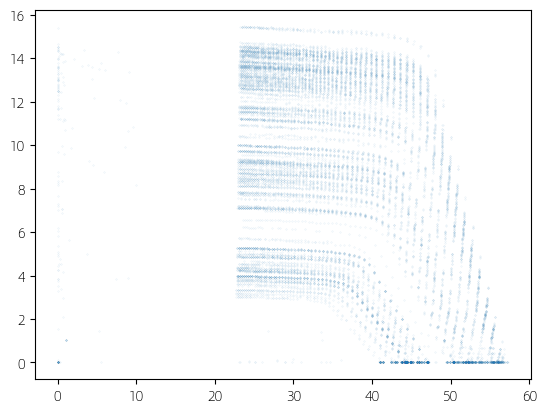

In [266]:
plt.plot(df.voltage,df.current,'o',alpha=0.2,markersize=0.2)

Text(0.5, 1.0, '组件在不同环境下的PV曲线')

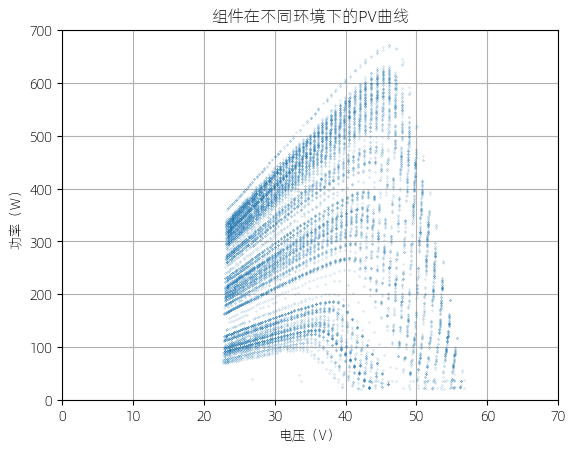

In [267]:


df = df[df.voltage>=20]
df = df[df.power>20]
plt.plot(df.voltage,df.power,'o',alpha=0.6,markersize=0.2)
plt.xlim(0,70)
plt.ylim(0,700)
plt.xlabel('电压（V）')
plt.ylabel('功率（W）')
plt.grid()
plt.title('组件在不同环境下的PV曲线')

Text(0.5, 1.0, '组件在不同环境下的IV曲线')

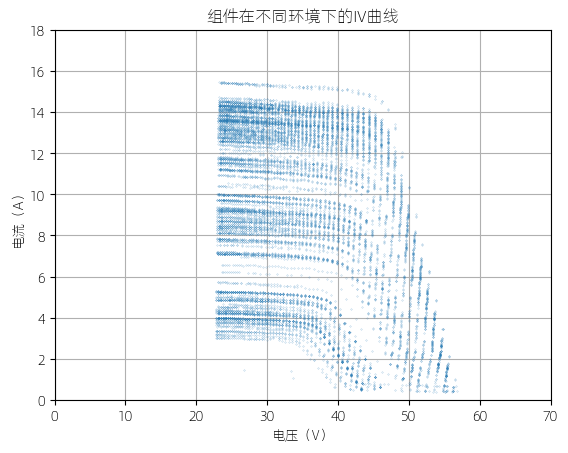

In [268]:
plt.plot(df.voltage,df.current,'o',alpha=0.6,markersize=0.2)
plt.xlim(0,70)
plt.ylim(0,18)
plt.xlabel('电压（V）')
plt.ylabel('电流（A）')
plt.grid()
plt.title('组件在不同环境下的IV曲线')

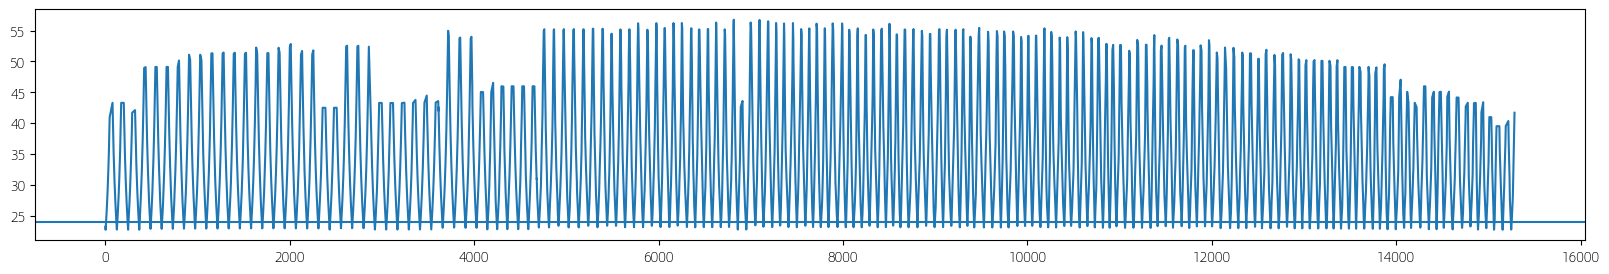

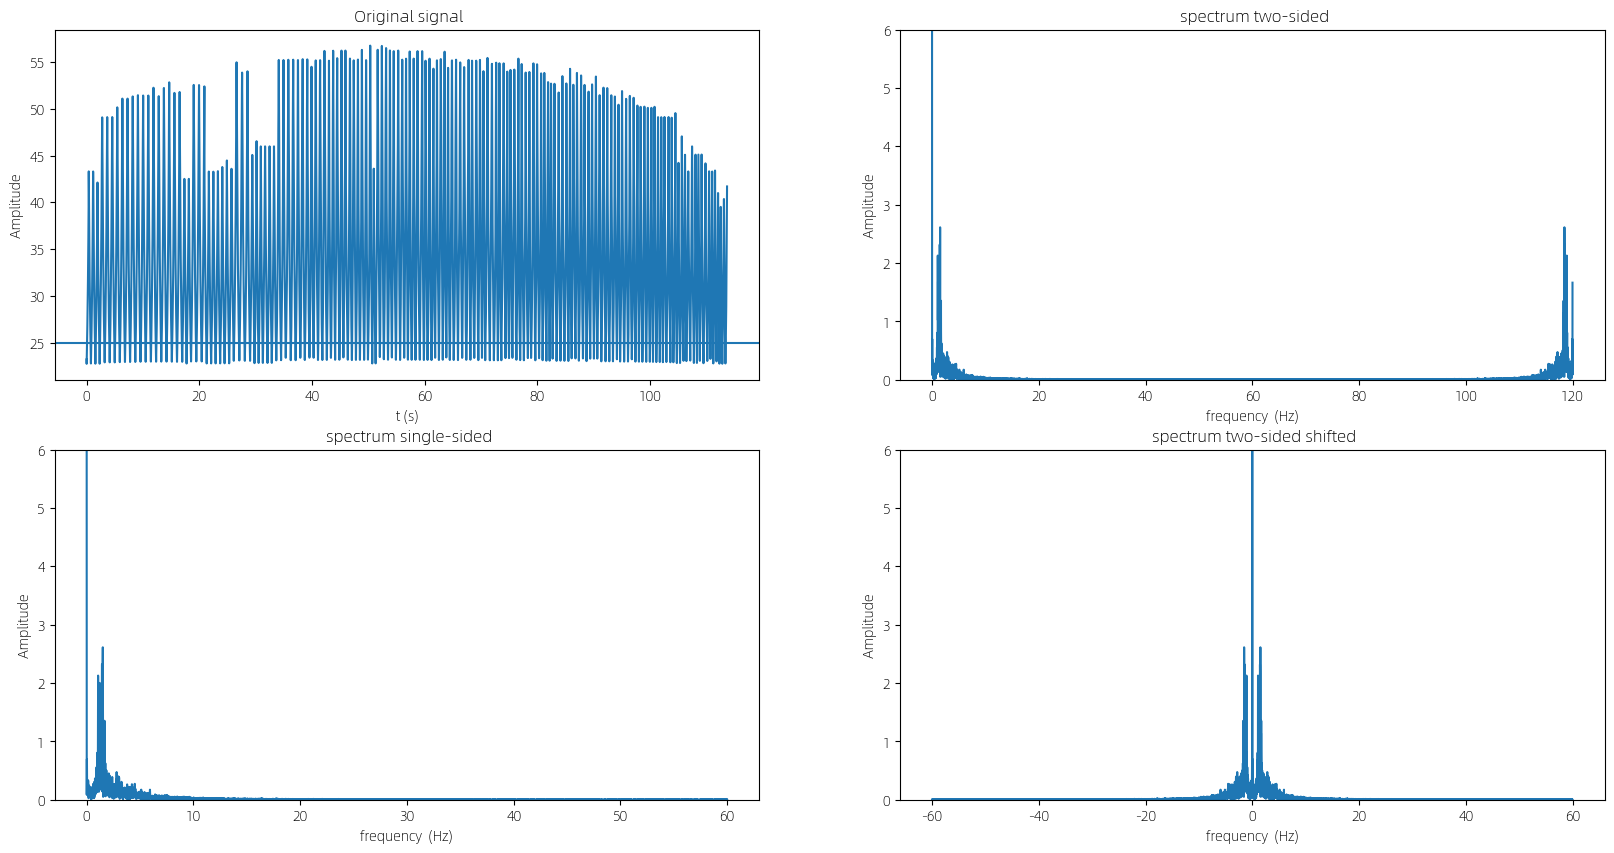

In [269]:
df.voltage.plot(figsize=[20,3])
plt.axhline(24)
from scipy.fftpack import fft,ifft,fftshift
import numpy as np

signal = df.voltage.values
fft_data = fft(signal)
N = df.shape[0]
sample_freq=120                 # 采样频率 120 Hz, 大于两倍的最高频率
sample_interval=1/sample_freq   # 采样间隔
signal_len=N*sample_interval    # 信号长度
t=np.arange(0,signal_len,sample_interval)

# 在python的计算方式中，fft结果的直接取模和真实信号的幅值不一样。
# 对于非直流量的频率，直接取模幅值会扩大N/2倍， 所以需要除了N乘以2。
# 对于直流量的频率(0Hz)，直接取模幅值会扩大N倍，所以需要除了N。
fft_amp0 = np.array(np.abs(fft_data)/N*2)   # 用于计算双边谱
fft_amp0[0]=0.5*fft_amp0[0]
N_2 = int(N/2)
fft_amp1 = fft_amp0[0:N_2]  # 单边谱
fft_amp0_shift = fftshift(fft_amp0)    # 使用fftshift将信号的零频移动到中间

# 计算频谱的频率轴
list0 = np.array(range(0, N))
list1 = np.array(range(0, int(N/2)))
list0_shift = np.array(range(0, N))
freq0 = sample_freq*list0/N        # 双边谱的频率轴
freq1 = sample_freq*list1/N        # 单边谱的频率轴
freq0_shift=sample_freq*list0_shift/N-sample_freq/2  # 零频移动后的频率轴

# 绘制结果
plt.figure(figsize=[20,10])
# 原信号
plt.subplot(221)
plt.plot(t, signal)
plt.title(' Original signal')
plt.axhline(25)
plt.xlabel('t (s)')
plt.ylabel(' Amplitude ')
# 双边谱
plt.subplot(222)
plt.plot(freq0, fft_amp0)
plt.title(' spectrum two-sided')
plt.ylim(0, 6)
plt.xlabel('frequency  (Hz)')
plt.ylabel(' Amplitude ')
# 单边谱
plt.subplot(223)
plt.plot(freq1, fft_amp1)
plt.title(' spectrum single-sided')
plt.ylim(0, 6)
plt.xlabel('frequency  (Hz)')
plt.ylabel(' Amplitude ')
# 移动零频后的双边谱
plt.subplot(224)
plt.plot(freq0_shift, fft_amp0_shift)
plt.title(' spectrum two-sided shifted')
plt.xlabel('frequency  (Hz)')
plt.ylabel(' Amplitude ')
plt.ylim(0, 6)

plt.show()



/var/folders/s5/xbvm2xtj3wq717lj2kf2s1j80000gn/T/ipykernel_29343/532166027.py:8: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  lag = arange(len(tempNorm))


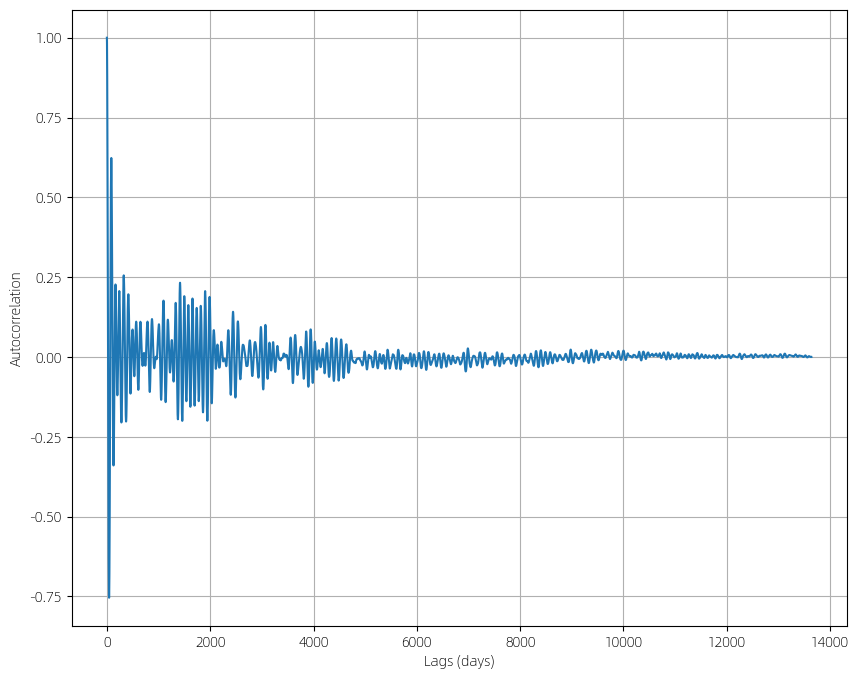

In [270]:
from scipy import fft, arange, signal
from statsmodels import api as sm
import scipy.io as sio

tempNorm=df.voltage.values
acf = sm.tsa.acf(tempNorm, nlags=len(tempNorm))
plt.figure(figsize = (10, 8))
lag = arange(len(tempNorm))
plt.plot(lag, acf)
# plt.xlim((40, 50))
plt.xlabel('Lags (days)')
plt.ylabel('Autocorrelation')
plt.grid()


In [271]:
acf.sort()
acf

array([-0.75436085, -0.75321978, -0.7514517 , ...,  0.98429225,
        0.99563663,  1.        ])

In [272]:
# from sklearn import metrics   
# import numpy as np
# X = np.array(df[['voltage','power']])
# db = DBSCAN(eps=0.5, min_samples=4,algorithm='auto',metric='minkowski',p=2).fit(X) #DBSCAN聚类方法 还有参数，matric = ""距离计算方法
# labels = db.labels_  #和X同一个维度，labels对应索引序号的值 为她所在簇的序号。若簇编号为-1，表示为噪声

# print('每个样本的簇标号:')
# print(labels)

# raito = len(labels[labels[:] == -1]) / len(labels)  #计算噪声点个数占总数的比例
# print('噪声比:', format(raito, '.2%'))

# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  # 获取分簇的数目

# print('分簇的数目: %d' % n_clusters_)
# print("轮廓系数: %0.3f" % metrics.silhouette_score(X, labels)) #轮廓系数评价聚类的好坏

# for i in range(n_clusters_):
#     # print('簇 ', i, '的所有样本:')
#     one_cluster = X[labels == i]
#     # print(one_cluster)
#     plt.plot(one_cluster[:,0],one_cluster[:,1],'o',alpha=0.6,markersize=0.5)
# plt.xlim(0,1.2*df.voltage.max())
# plt.show()


In [273]:
import math

from scipy.optimize import fsolve  
from scipy.optimize import curve_fit       

# alpha = 0.0025
# beta = 0.5
# gamma = 0.00288

alpha = -0.0358
beta = 0.35
gamma = 0.00288

S_std = 1000
T_std = 25
class PVpanel:
    def __init__(
        self,
        Immp: float = 1.0,
        Vmmp: float = 0.0,
        Isc:  float = 1.0,
        Voc:  float = 1.0,
        beta_Voc_pc: float = 0.5,
        alpha_Isc_pc: float = 0.0032,
    ):
        self.Immp = Immp
        self.Vmmp = Vmmp
        self.Isc = Isc
        self.Voc = Voc
        self.beta_Voc_pc = beta_Voc_pc
        self.alpha_Isc_pc = alpha_Isc_pc
        
        self.C2 = (self.Vmmp/self.Voc-1)/np.log(1-(self.Immp/self.Isc))
        self.C1 = (1-(self.Immp/self.Isc))*np.exp(-self.Vmmp/(self.C2*self.Voc))
    
    
    def func_pv(self,voltage_pv,T,S):
        dT = T - T_std
        dS = S/S_std -1
        u_oc_new = self.Voc*(1-gamma*dT)*(1+beta*dS)
        u_mmp_new = self.Vmmp*(1+gamma*dT)*(1+beta*dS)
        i_sc_new = self.Isc*(1+alpha*dT)*S/S_std
        i_mmp_new = self.Immp*(1+alpha*dT)*S/S_std
        c2 = (u_mmp_new/u_oc_new-1)/np.log(1-(i_mmp_new/i_sc_new))
        c1 = (1-(i_mmp_new/i_sc_new))*np.exp(-u_mmp_new/(c2*u_oc_new))
        current = i_sc_new*(1 - c1*(np.exp(voltage_pv/(c2*u_oc_new))-1))
        return current


    def generate_pv_curve(self, v:list,i:list, label):
        # 通过若干个点，得到当前的辐照和温度
        S,T = simulate(v,i)
        # S,T = 800,26
        # print('辐照',S,'气温',T)
        dT = T - T_std
        dS = S/S_std -1
        u_oc_new = self.Voc*(1-gamma*dT)*(1+beta*dS)
        u_mmp_new = self.Vmmp*(1+gamma*dT)*(1+beta*dS)
        # print(dS,dT)
        i_sc_new = self.Isc*(1+alpha*dT)*S/S_std
        i_mmp_new = self.Immp*(1+alpha*dT)*S/S_std
        # print(u_oc_new,u_mmp_new,i_sc_new,i_mmp_new)
        c2 = (u_mmp_new/u_oc_new-1)/np.log(1-(i_mmp_new/i_sc_new))
        c1 = (1-(i_mmp_new/i_sc_new))*np.exp(-u_mmp_new/(c2*u_oc_new))
        # print('组件参数',u_oc_new,u_mmp_new,i_sc_new,i_mmp_new)
        voltage = np.arange(0,u_oc_new,0.01)
        current = i_sc_new*(1 - c1*(np.exp(voltage/(c2*u_oc_new))-1))
        # print(len(current),len(voltage))
        plot_curve(voltage,current,v,i,label,S,T)
        result = dict()
        result['irr'] = S
        result['temp'] = T
        result['i_sc_new'] =i_sc_new
        result['i_mmp_new'] =i_mmp_new
        result['u_oc_new'] =u_oc_new
        result['u_mmp_new'] =u_mmp_new
        return result


def plot_curve(u_pv,i_pv,u_real,i_real,mark,irr,temp):
    p_pv = (u_pv*i_pv)
    p_real = u_real*i_real
    fig, ax1 = plt.subplots()
    ax1.plot(u_pv,i_pv,'--',markersize=0.1,label='i-v',color='#00ff00')
    ax1.plot(u_real,i_real,'+',markersize=0.5,label='i-v_real',color='#00ff00')
    plt.legend(loc='upper left')
    plt.ylim(0,1.1*pv.Isc)
    ax2 = ax1.twinx()  
    # ax2 = ax1.twinx()  
    plt.grid()
    ax2.plot(u_pv,p_pv,'--',markersize=0.1,label='p-v',color ='#892347')
    ax2.plot(u_real,p_real,'+',markersize=0.5,label='p-v_real',color ='#892347')
    plt.xlim(0,70)
    plt.ylim(0,1.1*pv.Immp*pv.Vmmp)
    plt.legend(loc='upper right')
    plt.title('标签--{}  辐照--{}  温度--{}'.format(mark,round(irr,2),round(temp,2)))


def simulate(xdata:list,ydata:list):
    # print(xdata,ydata)
    popt, pcov = curve_fit(pv.func_pv, xdata, ydata,p0=[15.9,169],bounds=([15.8,0],[40,1000]))
    # print(popt,pcov)
    temperature = popt[0]
    irr = popt[1]
    # print(irr,temperature)
    return irr,temperature
 


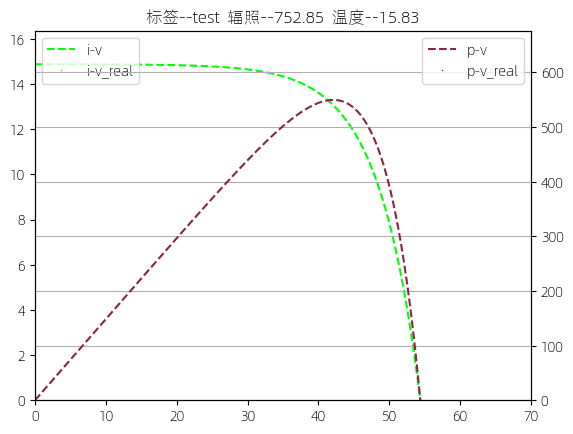

In [274]:
pv = PVpanel(Immp = 13.46,Vmmp = 45.69,Isc = 14.87,Voc = 58) 
u_pv = np.arange(0,pv.Voc,0.01)
i_pv = pv.Isc*(1 - pv.C1*(np.exp(u_pv/(pv.C2*pv.Voc))-1))
res = pv.generate_pv_curve(u_pv[0:3],i_pv[0:3],'test')

#
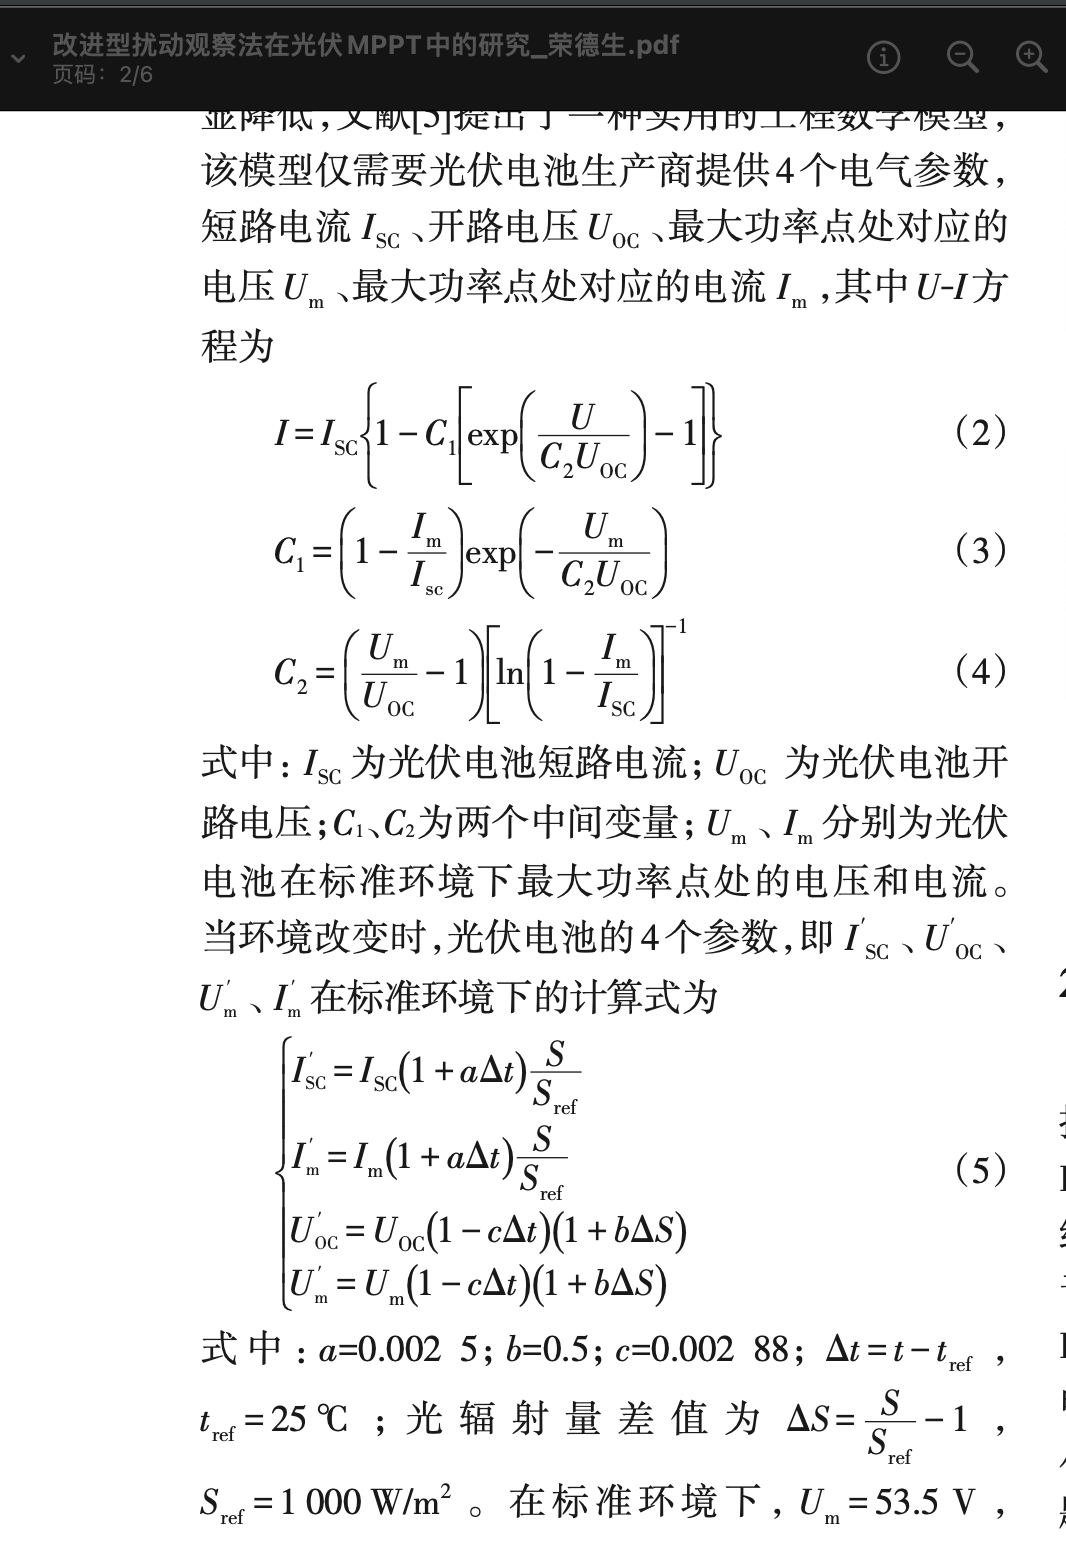

In [275]:
# plot_curve(df.voltage,df.current)
l = 0
for i in range(df.shape[0]):
    if df.at[df.index[i],'voltage']<25:
        l+=1
    df.at[df.index[i],'label'] = int(l)

In [276]:
res=dict()
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=2, min_samples=2,algorithm='auto',metric='minkowski',p=2).fit(ss[['voltage','current']].values) 
df['label_2'] = df['label']

for ll in df.label.unique():
    df_ll = df[df.label==ll]
    if df_ll.shape[0]<30:
        continue
    # if ll >11:
    #     continue
    if df_ll.shape[0] > 60:
        df_lla = df_ll[df_ll.index <= df_ll.voltage.idxmax()]
        # print(df_ll.index.min(),df_ll.index.max())
        df.loc[df_ll.index.min():df_ll.voltage.idxmax(),'label_2'] = '-'.join([str(ll),'a'])
        df.loc[df_ll.voltage.idxmax()+1:df_ll.index.max(),'label_2'] = '-'.join([str(ll),'b'])
        df_llb = df_ll[df_ll.index > df_ll.voltage.idxmax()]
#         res['-'.join([str(ll),'a'])] = pv.generate_pv_curve(df_lla.voltage,df_lla.current,'-'.join([str(ll),'a']))
#         lenth = {'lenth':df_lla.shape[0]}
#         res['-'.join([str(ll),'a'])].update(lenth)
                                                       
#         res['-'.join([str(ll),'b'])] = pv.generate_pv_curve(df_llb.voltage,df_llb.current,'-'.join([str(ll),'b']))
#         lenth = {'lenth':df_lla.shape[0]}
#         res['-'.join([str(ll),'b'])].update(lenth)
for ll in df.label_2.unique():
    df_ll = df[df.label_2==ll]
    if df_ll.shape[0]<30:
        continue
    X = df[df.label_2 ==ll][['voltage','current']].values
    db = DBSCAN(eps=5, min_samples=2,algorithm='auto',metric='euclidean').fit(X)
    # print(set(db.labels_))
    df.loc[df_ll.index.min():df_ll.index.max(),'label_3'] = db.labels_


In [277]:
df['final_label'] = df.apply(lambda x: '-'.join([str(x['label_2']),str(x['label_3'])]),axis=1)
df.dropna(subset=['label_3'],inplace=True)

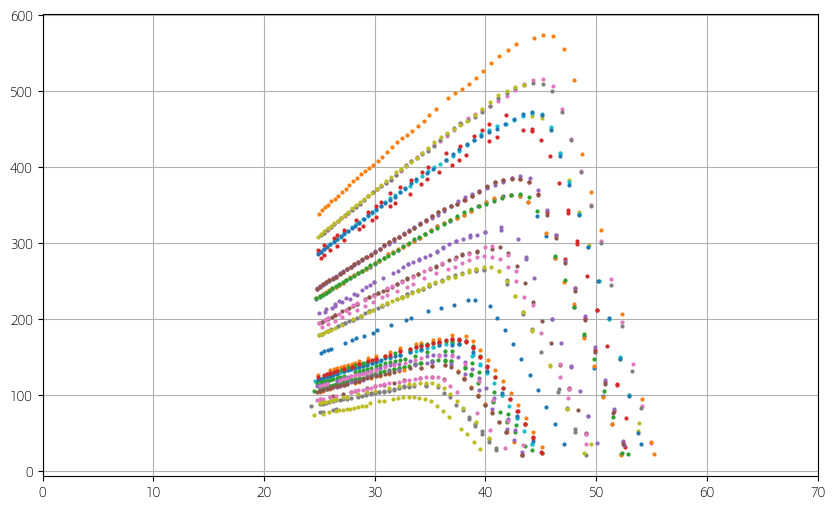

In [278]:
fig = plt.figure(figsize=[10,6])
for ll in df.final_label.unique():
    df_l = df[df.final_label == ll]
    if df_l.shape[0]>=50:
        plt.plot(df_l.voltage,df_l.power,'o',markersize=2)
plt.xlim(0,70)
plt.grid()    

In [279]:
tmp = df.groupby('final_label').count().sort_values('voltage')

In [280]:
drop_label = list(tmp[tmp['voltage'] <= 15].index)

In [281]:
df['tag'] = df.apply(lambda x:x['final_label'] in drop_label,axis=1)

In [282]:
df=df[df['tag'] == False]
df['标签'] = pd.Categorical(df['final_label']).codes


In [283]:
df.to_csv('data/曲线打标.csv')

In [284]:
df.drop(columns=['label','label_2','label_3','final_label','tag'],inplace=True)

In [285]:
df.rename(columns={'标签':'label'},inplace=True)

In [286]:
df

,voltage,current,power,label
10,24.740,3.174,78.524760,18
11,25.016,3.170,79.300720,18
12,25.296,3.175,80.314800,18
13,25.586,3.175,81.235550,18
14,25.879,3.177,82.217583,18
...,...,...,...,...
15236,26.210,3.581,93.858010,154
15237,25.914,3.584,92.875776,154
15238,25.623,3.587,91.909701,154
15239,25.335,3.596,91.104660,154


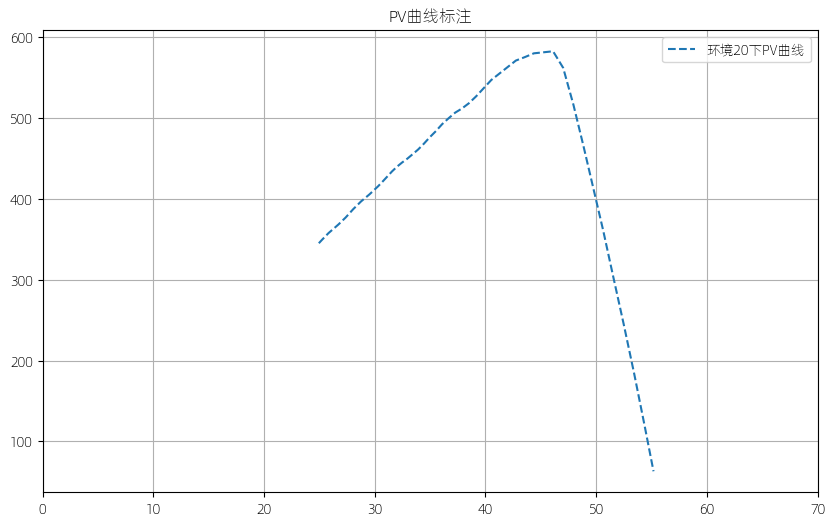

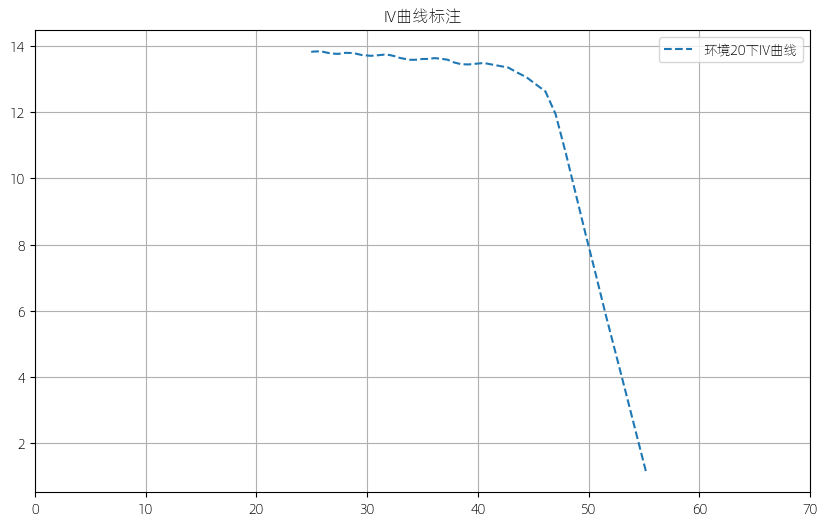

In [287]:
fig = plt.figure(figsize=[10,6])
for ll in df.label.sort_values().unique():
    df_l = df[df.label == ll]
    if df_l.shape[0]>=41 and ll==20:
        plt.plot(df_l.voltage,df_l.power,'--',markersize=2,label='环境{}下PV曲线'.format(ll))
        plt.legend()
    plt.title('PV曲线标注')
plt.xlim(0,70)
plt.grid()    
fig = plt.figure(figsize=[10,6])
for ll in df.label.sort_values().unique():
    df_l = df[df.label == ll]
    if df_l.shape[0]>=41 and ll==20:
        plt.plot(df_l.voltage,df_l.current,'--',markersize=2,label='环境{}下IV曲线'.format(ll))
        plt.legend()
    plt.title('IV曲线标注')
plt.xlim(0,70)
plt.grid()    

(0.0, 57.0)

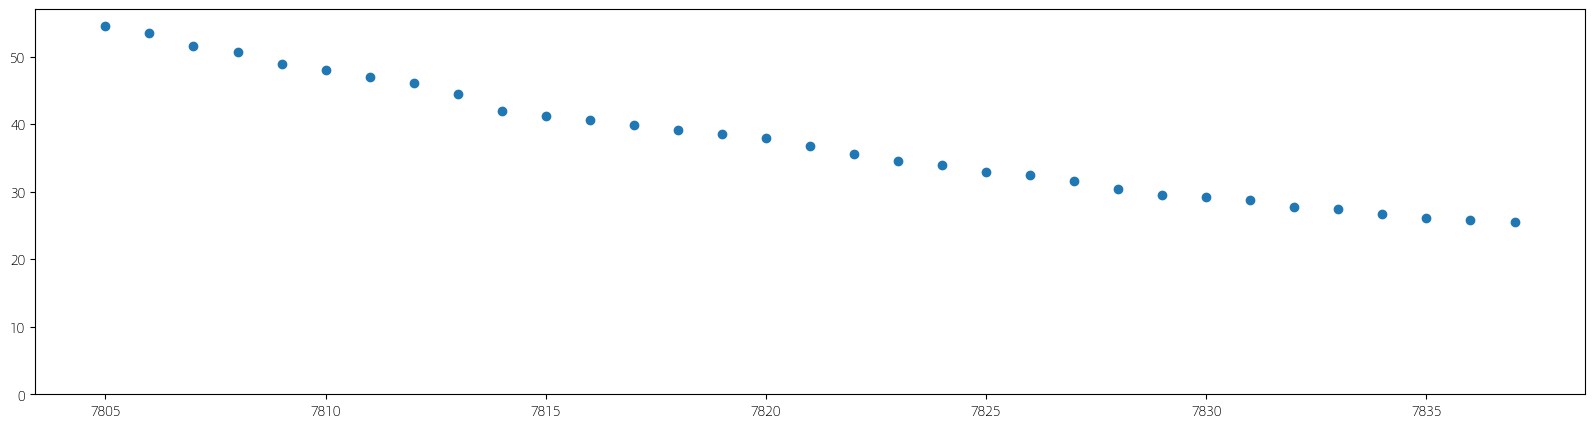

In [288]:
plt.figure(figsize=[20,5])
plt.plot(df_l.voltage,'o')
plt.ylim(0,57)

In [170]:
df_l.shape

(41, 4)

In [250]:
df_l = df[df.label == 20]
actions=[-10, -5, -3, -2, -1, -0.1, 0, 0.1, 1, 2, 3, 5, 10]
import numpy as np
from scipy.interpolate import interp1d
def inter1pd_iv_curve(v_near, data):
    xdata = data.voltage.values
    ydata = data.current.values
    func = interp1d(xdata, ydata, kind='linear', fill_value="extrapolate")
    # print(v_near)
    if v_near > xdata.max() or v_near < xdata.min():
        # print('电压月线图')
        return 0
    if v_near in data.voltage.values:
        return data[data.voltage == v_near].current.values[0]
    x_new = np.linspace(start=v_near-0.1, stop=v_near+0.1, num=10)
    y_new = func(x_new)
    y = np.maximum(y_new, 0)
    y = np.minimum(y, ydata.max())
    return y.mean()

In [299]:
# df_l.sort_values('power',ascending=False)
v_mpp = df_l.at[df_l['power'].idxmax(),'voltage']
p_mpp = df_l.at[df_l['power'].idxmax(),'power']
res = pd.DataFrame(index=df_l.voltage.values,columns=[i for i in range(1,15)])
for idx in df_l.sort_values('voltage').index:
    r_s = []
    p_t = df_l.at[idx,'power']
    v_t =  df_l.at[idx,'voltage']
    for i in range(len(actions)):
        delta_v = actions[i]
        v = np.clip(v_t + delta_v, 22, 56)
        current = inter1pd_iv_curve(v, df_l)
        dp = (v*current - p_t)
        # r = dp + 1/(abs(v-v_mpp) + 1e-4) + v*current
        r = 1000 + dp - 100*abs(v-v_mpp)
        r_s.append(r)
    state_reward= np.mean(r_s)
    r_s.append(state_reward)
    res.loc[v_t,]=r_s

In [300]:
res

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
54.552,1303.528498,960.820747,642.921644,484.749377,324.262963,173.230762,156.3,2.337272,-87.662728,-132.462728,-132.462728,-132.462728,-132.462728,263.895202
53.556,1127.162581,1050.532295,733.782745,574.431918,416.261593,272.046299,255.9,239.206012,-55.91398,-155.91398,-200.31398,-200.31398,-200.31398,296.657965
51.621,799.58082,1221.734589,925.444751,767.530036,608.803009,465.439725,449.4,433.702826,291.326861,130.441329,-176.999583,-314.899583,-314.899583,406.661938
50.699,643.591243,1184.675801,1016.704751,858.121105,700.540327,557.61438,541.6,525.773174,382.461607,224.189457,62.72907,-339.504383,-369.604383,460.684011
48.887,335.695172,889.466031,1099.174409,1030.302518,883.276105,739.030429,722.8,707.243476,566.03128,406.991746,248.054282,-73.580926,-474.43678,544.619057
47.949,170.189176,728.915724,945.28713,1048.268551,965.453395,831.817874,816.6,800.617755,655.918469,498.946132,339.874535,22.131178,-531.714221,560.946592
47.017,16.343442,578.570332,798.888643,904.702921,1007.648993,921.820308,909.8,894.802981,758.10309,597.692461,440.57607,122.679705,-579.315622,567.101025
46.115,-102.376477,461.942356,681.883377,791.949984,897.094305,989.729959,1000.0,988.091723,877.379338,724.73393,564.69534,248.161012,-597.03354,578.942408
44.392,-290.453197,276.265179,497.64525,607.493442,717.678947,816.705295,827.7,838.04408,930.935514,972.270481,840.99704,526.659954,-275.903625,560.464489
41.984,-539.605138,24.566812,254.000909,367.303839,477.229615,575.95146,586.9,597.93266,697.152601,807.240751,913.279996,925.352604,139.8686,448.244208


In [220]:
# df_l

In [315]:
# df_l.sort_values('power',ascending=False)
v_mpp = df_l.at[df_l['power'].idxmax(),'voltage']
p_mpp = df_l.at[df_l['power'].idxmax(),'power']
res = pd.DataFrame(index=df_l.voltage.values,columns=[i for i in range(1,15)])
for idx in df_l.sort_values('voltage').index:
    r_s = []
    p_t = df_l.at[idx,'power']
    v_t =  df_l.at[idx,'voltage']
    for i in range(len(actions)):
        delta_v = actions[i]
        v = np.clip(v_t + delta_v, 22, 56)
        current = inter1pd_iv_curve(v, df_l)
        dp = (v*current - p_t)
        # r = (v*current - p_t) + 1/(abs(v-v_mpp) + 1e-4) 
        if dp > 0:
            r = 1000 + 0.1*dp - 100*abs(v-v_mpp)
        else:
            r = 1000 + 2*dp - 100*abs(v-v_mpp)
        # print(r)
        r_s.append(r)
    state_reward= np.max(r_s)
    r_s.append(state_reward)
    res.loc[v_t,]=r_s

In [316]:
res

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
54.552,889.68285,686.752075,474.962164,369.144938,263.096296,166.993076,156.3,-141.625456,-231.625456,-276.425456,-276.425456,-276.425456,-276.425456,889.68285
53.556,782.406258,785.36323,573.688274,467.753192,361.936159,266.51463,255.9,232.512025,-267.72796,-367.72796,-412.12796,-412.12796,-412.12796,785.36323
51.621,575.498082,976.633459,767.004475,661.213004,555.340301,460.003973,449.4,428.005651,233.253723,11.482659,-503.399166,-641.299166,-641.299166,976.633459
50.699,476.919124,981.02758,859.110475,753.25211,647.494033,552.201438,541.6,519.946349,323.323213,106.778914,-116.14186,-720.608766,-750.708766,981.02758
48.887,283.049517,788.426603,989.397441,933.550252,828.84761,733.423043,722.8,701.686951,509.26256,291.183492,73.308565,-369.961851,-960.37356,989.397441
47.949,156.978351,687.951572,889.588713,989.886855,921.485339,827.121787,816.6,794.63551,595.236938,381.292264,163.14907,-272.337643,-1074.928442,989.886855
47.017,-57.513116,566.940664,791.068864,891.650292,991.944899,920.002031,909.8,889.805962,706.406181,485.584923,271.35214,-164.44059,-1170.131244,991.944899
46.115,-204.752953,423.884712,663.766755,783.899967,894.188609,989.459917,1000.0,986.183446,854.758677,649.467861,429.39068,-3.677977,-1205.56708,1000.0
44.392,-408.606393,224.830359,467.590499,587.286884,707.657894,815.71059,827.7,837.734408,928.023551,972.240961,809.69408,381.019908,-724.107251,972.240961
41.984,-666.110276,-37.766376,221.101817,347.707677,467.55923,575.00292,586.9,597.003266,687.92526,788.934075,889.538,914.32526,-133.3628,914.32526


In [198]:
state_reward

114964.65342863742

In [297]:
df['voltage'] = df['voltage'] *1e3
df['current'] = df['current'] *1e3
df.to_csv('data/600W_train_data.csv')

In [298]:
df

,voltage,current,power,label
10,24740.0,3174.0,78.524760,18
11,25016.0,3170.0,79.300720,18
12,25296.0,3175.0,80.314800,18
13,25586.0,3175.0,81.235550,18
14,25879.0,3177.0,82.217583,18
...,...,...,...,...
15236,26210.0,3581.0,93.858010,154
15237,25914.0,3584.0,92.875776,154
15238,25623.0,3587.0,91.909701,154
15239,25335.0,3596.0,91.104660,154


In [200]:
df.reset_index(inplace=True)

In [201]:
df.drop(columns=['index'],inplace=True)



In [202]:
df['voltage'] = df['voltage'] *1e3
df['current'] = df['current'] *1e3


In [203]:
df.shape

(11517, 4)

(40, 4)
(40, 4)
(40, 4)


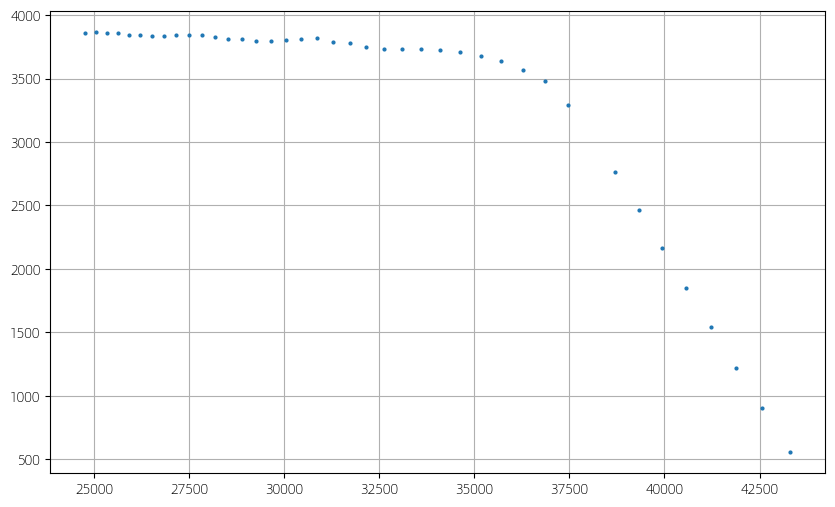

In [204]:
fig = plt.figure(figsize=[10,6])
i = 0
for ll in df.head(100).label.unique():
    i +=1
    df_l = df[df.label == 167]
    print(df_l.shape)
    # if df_l.shape[0]>=30:
    if i >=3:
        plt.plot(df_l.voltage,df_l.current,'o',markersize=2)
# plt.xlim(0,70)
plt.grid()    

In [205]:
df.head(100).label.unique()

array([ 18,  19, 167], dtype=int16)

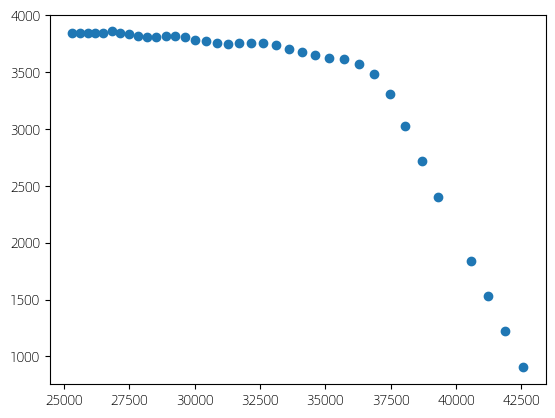

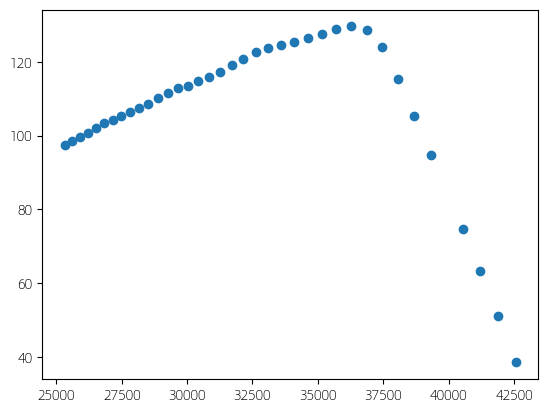

In [70]:
plt.plot(df_adapt.voltage,df_adapt.current,'o')
plt.figure()
plt.plot(df_adapt.voltage,df_adapt.power,'o')

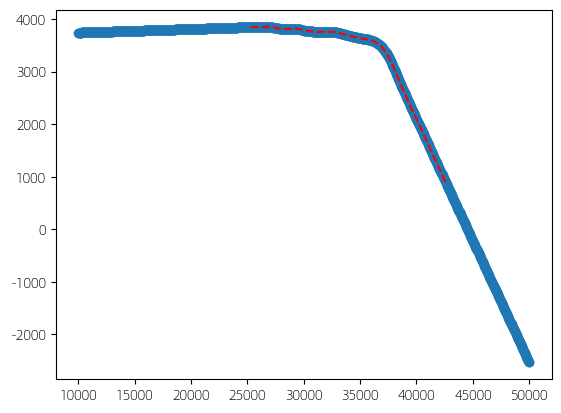

In [141]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# xdata=[1.0, 1.0185728, 1.0371457, 1.0557185, 1.0742913, 1.0928641, 1.111437, 1.1300098, 1.1485826, 1.1671554, 1.1857283, 1.2043011, 1.2228739, 1.2414467, 1.2600196, 1.2785924, 1.2971652, 1.315738, 1.3343109, 1.3528837, 1.3714565, 1.3900293, 1.4086022, 1.427175, 1.4457478, 1.4643206, 1.4828935, 1.5014663, 1.5200391, 1.5386119, 1.5571848, 1.5757576, 1.5943304, 1.6129032, 1.6314761, 1.6500489, 1.6686217, 1.6871945, 1.7057674, 1.7243402, 1.742913, 1.7614858, 1.7800587, 1.7986315, 1.8172043, 1.8357771, 1.85435, 1.8729228, 1.8914956, 1.9100684, 1.9286413, 1.9472141, 1.9657869, 1.9843597, 2.0029326, 2.0215054, 2.0400782, 2.058651, 2.0772239, 2.0957967, 2.1143695, 2.1329423, 2.1515152, 2.170088, 2.1886608, 2.2072336, 2.2258065, 2.2443793, 2.2629521, 2.2815249, 2.3000978, 2.3186706, 2.3372434, 2.3558162, 2.3743891, 2.3929619, 2.4115347, 2.4301075, 2.4486804, 2.4672532, 2.485826, 2.5043988, 2.5229717, 2.5415445, 2.5601173, 2.5786901, 2.597263, 2.6158358, 2.6344086, 2.6529814, 2.6715543, 2.6901271, 2.7086999, 2.7272727, 2.7458456, 2.7644184, 2.7829912, 2.801564, 2.8201369, 2.8387097, 2.8572825, 2.8758553, 2.8944282, 2.913001, 2.9315738, 2.9501466, 2.9687195, 2.9872923, 3.0058651, 3.0244379, 3.0430108, 3.0615836, 3.0801564, 3.0987292, 3.1173021, 3.1358749, 3.1544477, 3.1730205, 3.1915934, 3.2101662, 3.228739, 3.2473118, 3.2658847, 3.2844575, 3.3030303, 3.3216031, 3.340176, 3.3587488, 3.3773216, 3.3958944, 3.4144673, 3.4330401, 3.4516129, 3.4701857, 3.4887586, 3.5073314, 3.5259042, 3.544477, 3.5630499, 3.5816227, 3.6001955, 3.6187683, 3.6373412, 3.655914, 3.6744868, 3.6930596, 3.7116325, 3.7302053, 3.7487781, 3.7673509, 3.7859238, 3.8044966, 3.8230694, 3.8416422, 3.8602151, 3.8787879, 3.8973607, 3.9159335, 3.9345064, 3.9530792, 3.971652, 3.9902248, 4.0087977, 4.0273705, 4.0459433, 4.0645161, 4.083089, 4.1016618, 4.1202346, 4.1388074, 4.1573803, 4.1759531, 4.1945259, 4.2130987, 4.2316716, 4.2502444, 4.2688172, 4.28739, 4.3059629, 4.3245357, 4.3431085, 4.3616813, 4.3802542, 4.398827, 4.4173998, 4.4359726, 4.4545455, 4.4731183, 4.4916911, 4.5102639, 4.5288368, 4.5474096, 4.5659824, 4.5845552, 4.6031281, 4.6217009, 4.6402737, 4.6588465, 4.6774194, 4.6959922, 4.714565, 4.7331378, 4.7517107, 4.7702835, 4.7888563, 4.8074291, 4.826002, 4.8445748, 4.8631476, 4.8817204, 4.9002933, 4.9188661, 4.9374389, 4.9560117, 4.9745846, 4.9931574, 5.0117302, 5.030303, 5.0488759, 5.0674487, 5.0860215, 5.1045943, 5.1231672, 5.14174, 5.1603128, 5.1788856, 5.1974585, 5.2160313, 5.2346041, 5.2531769, 5.2717498, 5.2903226, 5.3088954, 5.3274682, 5.3460411, 5.3646139, 5.3831867, 5.4017595, 5.4203324, 5.4389052, 5.457478, 5.4760508, 5.4946237, 5.5131965, 5.5317693, 5.5503421, 5.568915, 5.5874878, 5.6060606, 5.6246334, 5.6432063, 5.6617791, 5.6803519, 5.6989247, 5.7174976, 5.7360704, 5.7546432, 5.773216, 5.7917889, 5.8103617, 5.8289345, 5.8475073, 5.8660802, 5.884653, 5.9032258, 5.9217986, 5.9403715, 5.9589443, 5.9775171, 5.9960899, 6.0146628, 6.0332356, 6.0518084, 6.0703812, 6.0889541, 6.1075269, 6.1260997, 6.1446725, 6.1632454, 6.1818182, 6.200391, 6.2189638, 6.2375367, 6.2561095, 6.2746823, 6.2932551, 6.311828, 6.3304008, 6.3489736, 6.3675464, 6.3861193, 6.4046921, 6.4232649, 6.4418377, 6.4604106, 6.4789834, 6.4975562, 6.516129, 6.5347019, 6.5532747, 6.5718475, 6.5904203, 6.6089932, 6.627566, 6.6461388, 6.6647116, 6.6832845, 6.7018573, 6.7204301, 6.7390029, 6.7575758, 6.7761486, 6.7947214, 6.8132942, 6.8318671, 6.8504399, 6.8690127, 6.8875855, 6.9061584, 6.9247312, 6.943304, 6.9618768, 6.9804497, 6.9990225, 7.0175953, 7.0361681, 7.054741, 7.0733138, 7.0918866, 7.1104594, 7.1290323, 7.1476051, 7.1661779, 7.1847507, 7.2033236, 7.2218964, 7.2404692, 7.259042, 7.2776149, 7.2961877, 7.3147605, 7.3333333, 7.3519062, 7.370479, 7.3890518, 7.4076246, 7.4261975, 7.4447703, 7.4633431, 7.4819159, 7.5004888, 7.5190616, 7.5376344, 7.5562072, 7.5747801, 7.5933529, 7.6119257, 7.6304985, 7.6490714, 7.6676442, 7.686217, 7.7047898, 7.7233627, 7.7419355, 7.7605083, 7.7790811, 7.797654, 7.8162268, 7.8347996, 7.8533724, 7.8719453, 7.8905181, 7.9090909, 7.9276637, 7.9462366, 7.9648094, 7.9833822, 8.001955, 8.0205279, 8.0391007, 8.0576735, 8.0762463, 8.0948192, 8.113392, 8.1319648, 8.1505376, 8.1691105, 8.1876833, 8.2062561, 8.2248289, 8.2434018, 8.2619746, 8.2805474, 8.2991202, 8.3176931, 8.3362659, 8.3548387, 8.3734115, 8.3919844, 8.4105572, 8.42913, 8.4477028, 8.4662757, 8.4848485, 8.5034213, 8.5219941, 8.540567, 8.5591398, 8.5777126, 8.5962854, 8.6148583, 8.6334311, 8.6520039, 8.6705767, 8.6891496, 8.7077224, 8.7262952, 8.744868, 8.7634409, 8.7820137, 8.8005865, 8.8191593, 8.8377322, 8.856305, 8.8748778, 8.8934506, 8.9120235, 8.9305963, 8.9491691, 8.9677419, 8.9863148, 9.0048876, 9.0234604, 9.0420332, 9.0606061, 9.0791789, 9.0977517, 9.1163245, 9.1348974, 9.1534702, 9.172043, 9.1906158, 9.2091887, 9.2277615, 9.2463343, 9.2649071, 9.28348, 9.3020528, 9.3206256, 9.3391984, 9.3577713, 9.3763441, 9.3949169, 9.4134897, 9.4320626, 9.4506354, 9.4692082, 9.487781, 9.5063539, 9.5249267, 9.5434995, 9.5620723, 9.5806452, 9.599218, 9.6177908, 9.6363636, 9.6549365, 9.6735093, 9.6920821, 9.7106549, 9.7292278, 9.7478006, 9.7663734, 9.7849462, 9.8035191, 9.8220919, 9.8406647, 9.8592375, 9.8778104, 9.8963832, 9.914956, 9.9335288, 9.9521017, 9.9706745, 9.9892473, 10.00782, 10.026393, 10.044966, 10.063539, 10.082111, 10.100684, 10.119257, 10.13783, 10.156403, 10.174976, 10.193548, 10.212121, 10.230694, 10.249267, 10.26784, 10.286413, 10.304985, 10.323558, 10.342131, 10.360704, 10.379277, 10.397849, 10.416422, 10.434995, 10.453568, 10.472141, 10.490714, 10.5, 10.509286, 10.527859, 10.546432, 10.565005, 10.583578, 10.602151, 10.620723, 10.639296, 10.657869, 10.676442, 10.695015, 10.713587, 10.73216, 10.750733, 10.769306, 10.787879, 10.806452, 10.825024, 10.843597, 10.86217, 10.880743, 10.899316, 10.917889, 10.936461, 10.955034, 10.973607, 10.99218, 11.010753, 11.029326, 11.047898, 11.066471, 11.085044, 11.103617, 11.12219, 11.140762, 11.159335, 11.177908, 11.196481, 11.215054, 11.233627, 11.252199, 11.270772, 11.289345, 11.307918, 11.326491, 11.345064, 11.363636, 11.382209, 11.400782, 11.419355, 11.437928, 11.4565, 11.475073, 11.493646, 11.512219, 11.530792, 11.549365, 11.567937, 11.58651, 11.605083, 11.623656, 11.642229, 11.660802, 11.679374, 11.697947, 11.71652, 11.735093, 11.753666, 11.772239, 11.790811, 11.809384, 11.827957, 11.84653, 11.865103, 11.883675, 11.902248, 11.920821, 11.939394, 11.957967, 11.97654, 11.995112, 12.013685, 12.032258, 12.050831, 12.069404, 12.087977, 12.106549, 12.125122, 12.143695, 12.162268, 12.180841, 12.199413, 12.217986, 12.236559, 12.255132, 12.273705, 12.292278, 12.31085, 12.329423, 12.347996, 12.366569, 12.385142, 12.403715, 12.422287, 12.44086, 12.459433, 12.478006, 12.496579, 12.515152, 12.533724, 12.552297, 12.57087, 12.589443, 12.608016, 12.626588, 12.645161, 12.663734, 12.682307, 12.70088, 12.719453, 12.738025, 12.756598, 12.775171, 12.793744, 12.812317, 12.83089, 12.849462, 12.868035, 12.886608, 12.905181, 12.923754, 12.942326, 12.960899, 12.979472, 12.998045, 13.016618, 13.035191, 13.053763, 13.072336, 13.090909, 13.109482, 13.128055, 13.146628, 13.1652, 13.183773, 13.202346, 13.220919, 13.239492, 13.258065, 13.276637, 13.29521, 13.313783, 13.332356, 13.350929, 13.369501, 13.388074, 13.406647, 13.42522, 13.443793, 13.462366, 13.480938, 13.499511, 13.518084, 13.536657, 13.55523, 13.573803, 13.592375, 13.610948, 13.629521, 13.648094, 13.666667, 13.685239, 13.703812, 13.722385, 13.740958, 13.759531, 13.778104, 13.796676, 13.815249, 13.833822, 13.852395, 13.870968, 13.889541, 13.908113, 13.926686, 13.945259, 13.963832, 13.982405, 14.000978, 14.01955, 14.038123, 14.056696, 14.075269, 14.093842, 14.112414, 14.130987, 14.14956, 14.168133, 14.186706, 14.205279, 14.223851, 14.242424, 14.260997, 14.27957, 14.298143, 14.316716, 14.335288, 14.353861, 14.372434, 14.391007, 14.40958, 14.428152, 14.446725, 14.465298, 14.483871, 14.502444, 14.521017, 14.539589, 14.558162, 14.576735, 14.595308, 14.613881, 14.632454, 14.651026, 14.669599, 14.688172, 14.706745, 14.725318, 14.743891, 14.762463, 14.781036, 14.799609, 14.818182, 14.836755, 14.855327, 14.8739, 14.892473, 14.911046, 14.929619, 14.948192, 14.966764, 14.985337, 15.00391, 15.022483, 15.041056, 15.059629, 15.078201, 15.096774, 15.115347, 15.13392, 15.152493, 15.171065, 15.189638, 15.208211, 15.226784, 15.245357, 15.25, 15.26393, 15.282502, 15.301075, 15.319648, 15.338221, 15.356794, 15.375367, 15.393939, 15.412512, 15.431085, 15.449658, 15.468231, 15.486804, 15.505376, 15.523949, 15.542522, 15.561095, 15.579668, 15.59824, 15.616813, 15.635386, 15.653959, 15.672532, 15.691105, 15.709677, 15.72825, 15.746823, 15.765396, 15.783969, 15.802542, 15.821114, 15.839687, 15.85826, 15.876833, 15.895406, 15.913978, 15.932551, 15.951124, 15.969697, 15.98827, 16.006843, 16.025415, 16.043988, 16.062561, 16.081134, 16.099707, 16.11828, 16.136852, 16.155425, 16.173998, 16.192571, 16.211144, 16.229717, 16.248289, 16.266862, 16.285435, 16.304008, 16.322581, 16.341153, 16.359726, 16.378299, 16.396872, 16.415445, 16.434018, 16.45259, 16.471163, 16.489736, 16.508309, 16.526882, 16.545455, 16.564027, 16.5826, 16.601173, 16.619746, 16.638319, 16.656891, 16.675464, 16.694037, 16.71261, 16.731183, 16.749756, 16.768328, 16.786901, 16.805474, 16.824047, 16.84262, 16.861193, 16.879765, 16.898338, 16.916911, 16.935484, 16.954057, 16.97263, 16.991202, 17.009775, 17.028348, 17.046921, 17.065494, 17.084066, 17.102639, 17.121212, 17.139785, 17.158358, 17.176931, 17.195503, 17.214076, 17.232649, 17.251222, 17.269795, 17.288368, 17.30694, 17.325513, 17.344086, 17.362659, 17.381232, 17.399804, 17.418377, 17.43695, 17.455523, 17.474096, 17.492669, 17.511241, 17.529814, 17.548387, 17.56696, 17.585533, 17.604106, 17.622678, 17.641251, 17.659824, 17.678397, 17.69697, 17.715543, 17.734115, 17.752688, 17.771261, 17.789834, 17.808407, 17.826979, 17.845552, 17.864125, 17.882698, 17.901271, 17.919844, 17.938416, 17.956989, 17.975562, 17.994135, 18.012708, 18.031281, 18.049853, 18.068426, 18.086999, 18.105572, 18.124145, 18.142717, 18.16129, 18.179863, 18.198436, 18.217009, 18.235582, 18.254154, 18.272727, 18.2913, 18.309873, 18.328446, 18.347019, 18.365591, 18.384164, 18.402737, 18.42131, 18.439883, 18.458456, 18.477028, 18.495601, 18.514174, 18.532747, 18.55132, 18.569892, 18.588465, 18.607038, 18.625611, 18.644184, 18.662757, 18.681329, 18.699902, 18.718475, 18.737048, 18.755621, 18.774194, 18.792766, 18.811339, 18.829912, 18.848485, 18.867058, 18.88563, 18.904203, 18.922776, 18.941349, 18.959922, 18.978495, 18.997067, 19.01564, 19.034213, 19.052786, 19.071359, 19.089932, 19.108504, 19.127077, 19.14565, 19.164223, 19.182796, 19.201369, 19.219941, 19.238514, 19.257087, 19.27566, 19.294233, 19.312805, 19.331378, 19.349951, 19.368524, 19.387097, 19.40567, 19.424242, 19.442815, 19.461388, 19.479961, 19.498534, 19.517107, 19.535679, 19.554252, 19.572825, 19.591398, 19.609971, 19.628543, 19.647116, 19.665689, 19.684262, 19.702835, 19.721408, 19.73998, 19.758553, 19.777126, 19.795699, 19.814272, 19.832845, 19.851417, 19.86999, 19.888563, 19.907136, 19.925709, 19.944282, 19.962854, 19.981427, 20.0]
# ydata=[-0.00026077789, -9.6432747e-16, -9.6432747e-16, -9.6432747e-16, 0.0, 0.0, 0.0, 0.0, -9.6432747e-16, 0.0, 0.0, 0.0, 0.0, -1.9286549e-15, 0.0, -9.6432747e-16, -9.6432747e-16, 0.0, -9.6432747e-16, 0.0, 0.0, 0.0, -9.6432747e-16, 0.0, 0.0, -9.6432747e-16, -9.6432747e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -9.6432747e-16, 1.9286549e-15, -9.6432747e-16, -9.6432747e-16, -9.6432747e-16, -9.6432747e-16, 0.0, 0.0, -9.6432747e-16, 0.0, -9.6432747e-16, -9.6432747e-16, 0.0, -9.6432747e-16, -9.6432747e-16, -9.6432747e-16, -9.6432747e-16, 0.0, -9.6432747e-16, -9.6432747e-16, 0.0, 0.0, 0.0, -9.6432747e-16, -9.6432747e-16, 0.0, 0.0, 0.0, 0.0, 0.0, -9.6432747e-16, 0.0, -9.6432747e-16, -9.6432747e-16, 0.0, 0.0, -1.9286549e-15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -9.6432747e-16, -9.6432747e-16, 0.0, 0.0, 0.0, -0.00026598827, -0.00074931163, -0.0012412449, -0.0017417588, -0.0022508257, -0.0027684194, -0.0032945152, -0.0038290898, -0.0043721214, -0.0049235899, -0.0054834764, -0.0060517635, -0.0066284354, -0.0072134777, -0.0078068772, -0.0084086225, -0.0090187034, -0.0096371112, -0.010263839, -0.01089888, -0.01154223, -0.012193887, -0.012853847, -0.013522112, -0.014198682, -0.01488356, -0.015576749, -0.016278254, -0.016988082, -0.017706241, -0.018432739, -0.019167587, -0.019910798, -0.020662383, -0.021422357, -0.022190737, -0.022967538, -0.023752779, -0.024546479, -0.025348659, -0.026159341, -0.026978548, -0.027806305, -0.028642636, -0.029487569, -0.030341132, -0.031203354, -0.032074264, -0.032953896, -0.033842281, -0.034739453, -0.035645447, -0.0365603, -0.037484048, -0.03841673, -0.039358386, -0.040309055, -0.04126878, -0.042237603, -0.043215569, -0.044202721, -0.045199105, -0.04620477, -0.047219761, -0.04824413, -0.049277925, -0.050321197, -0.051373999, -0.052436384, -0.053508404, -0.054590116, -0.055681575, -0.056782838, -0.057893962, -0.059015006, -0.06014603, -0.061287093, -0.062438258, -0.063599587, -0.064771142, -0.065952987, -0.067145187, -0.068347809, -0.069560917, -0.07078458, -0.072018866, -0.073263843, -0.074519581, -0.07578615, -0.077063622, -0.078352069, -0.079651562, -0.080962177, -0.082283986, -0.083617065, -0.084961489, -0.086317335, -0.087684679, -0.0890636, -0.090454175, -0.091856483, -0.093270604, -0.094696619, -0.096134608, -0.097584652, -0.099046834, -0.10052124, -0.10200794, -0.10350704, -0.1050186, -0.10654272, -0.10807949, -0.10962898, -0.11119129, -0.1127665, -0.1143547, -0.11595598, -0.11757042, -0.11919812, -0.12083916, -0.12249364, -0.12416165, -0.12584327, -0.1275386, -0.12924773, -0.13097074, -0.13270775, -0.13445883, -0.13622408, -0.13800359, -0.13979746, -0.14160579, -0.14342866, -0.14526617, -0.14711843, -0.14898551, -0.15086752, -0.15276456, -0.15467672, -0.1566041, -0.1585468, -0.16050491, -0.16247853, -0.16446777, -0.1664727, -0.16849345, -0.1705301, -0.17258275, -0.17465151, -0.17673646, -0.17883772, -0.18095538, -0.18308954, -0.1852403, -0.18740776, -0.18959202, -0.19179319, -0.19401135, -0.19624662, -0.19849909, -0.20076886, -0.20305604, -0.20536073, -0.20768302, -0.21002302, -0.21238083, -0.21475655, -0.21715028, -0.21956213, -0.22199219, -0.22444057, -0.22690737, -0.22939269, -0.23189663, -0.23441929, -0.23696078, -0.23952119, -0.24210064, -0.24469921, -0.24731701, -0.24995414, -0.25261071, -0.25528682, -0.25798256, -0.26069804, -0.26343336, -0.26618862, -0.26896392, -0.27175936, -0.27457505, -0.27741108, -0.28026756, -0.28314458, -0.28604225, -0.28896067, -0.29189993, -0.29486014, -0.2978414, -0.30084381, -0.30386746, -0.30691246, -0.30997891, -0.3130669, -0.31617654, -0.31930792, -0.32246115, -0.32563632, -0.32883352, -0.33205287, -0.33529445, -0.33855837, -0.34184472, -0.3451536, -0.34848511, -0.35183934, -0.35521639, -0.35861637, -0.36203936, -0.36548546, -0.36895477, -0.37244738, -0.37596339, -0.3795029, -0.38306599, -0.38665278, -0.39026334, -0.39389778, -0.39755618, -0.40123865, -0.40494528, -0.40867616, -0.41243138, -0.41621104, -0.42001522, -0.42384404, -0.42769756, -0.43157589, -0.43547912, -0.43940735, -0.44336065, -0.44733912, -0.45134286, -0.45537195, -0.45942649, -0.46350656, -0.46761225, -0.47174366, -0.47590087, -0.48008396, -0.48429304, -0.48852819, -0.49278948, -0.49707703, -0.5013909, -0.50573119, -0.51009799, -0.51449137, -0.51891144, -0.52335826, -0.52783194, -0.53233254, -0.53686017, -0.54141491, -0.54599683, -0.55060602, -0.55524257, -0.55990656, -0.56459807, -0.5693172, -0.57406401, -0.57883859, -0.58364103, -0.5884714, -0.59332979, -0.59821628, -0.60313095, -0.60807388, -0.61304516, -0.61804485, -0.62307305, -0.62812983, -0.63321526, -0.63832944, -0.64347244, -0.64864433, -0.6538452, -0.65907512, -0.66433417, -0.66962243, -0.67493998, -0.68028689, -0.68566323, -0.69106909, -0.69650455, -0.70196966, -0.70746452, -0.7129892, -0.71854377, -0.72412831, -0.72974288, -0.73538758, -0.74106246, -0.7467676, -0.75250308, -0.75826897, -0.76406534, -0.76989227, -0.77574982, -0.78163807, -0.78755709, -0.79350695, -0.79948772, -0.80549948, -0.8115423, -0.81761624, -0.82372138, -0.82985778, -0.83602551, -0.84222466, -0.84845527, -0.85471743, -0.86101121, -0.86733666, -0.87369386, -0.88008288, -0.88650379, -0.89295665, -0.89944153, -0.90595849, -0.91250762, -0.91908896, -0.92570259, -0.93234858, -0.93902698, -0.94573788, -0.95248132, -0.95925738, -0.96606613, -0.97290762, -0.97978193, -0.98668911, -0.99362923, -1.0006024, -1.0076086, -1.0146479, -1.0217204, -1.0288262, -1.0359653, -1.0431378, -1.0503438, -1.0575833, -1.0648563, -1.072163, -1.0795033, -1.0868775, -1.0942854, -1.1017273, -1.1092031, -1.1167129, -1.1242567, -1.1318347, -1.1394469, -1.1470933, -1.154774, -1.1624892, -1.1702387, -1.1780227, -1.1858413, -1.1936944, -1.2015823, -1.2095048, -1.2174622, -1.2254544, -1.2334815, -1.2415435, -1.2496406, -1.2577727, -1.26594, -1.2741424, -1.2823801, -1.2906532, -1.2989615, -1.3073053, -1.3156846, -1.3240994, -1.3325497, -1.3410358, -1.3495575, -1.358115, -1.3667083, -1.3753374, -1.3840025, -1.3927035, -1.4014406, -1.4102138, -1.4190231, -1.4278686, -1.4367503, -1.4456684, -1.4546228, -1.4636136, -1.4726409, -1.4817047, -1.490805, -1.499942, -1.5091157, -1.5183261, -1.5275733, -1.5368573, -1.5461782, -1.555536, -1.5649308, -1.5743627, -1.5838316, -1.5933377, -1.602881, -1.6124616, -1.6220794, -1.6317346, -1.6414272, -1.6511572, -1.6609247, -1.6658225, -1.6707297, -1.6805724, -1.6904527, -1.7003707, -1.7103264, -1.72032, -1.7303513, -1.7404206, -1.7505278, -1.7606729, -1.7708562, -1.7810774, -1.7913369, -1.8016344, -1.8119702, -1.8223443, -1.8327567, -1.8432074, -1.8536966, -1.8642242, -1.8747903, -1.8853949, -1.8960382, -1.90672, -1.9174406, -1.9281998, -1.9389978, -1.9498347, -1.9607104, -1.9716249, -1.9825785, -1.993571, -2.0046025, -2.0156731, -2.0267828, -2.0379317, -2.0491197, -2.060347, -2.0716136, -2.0829195, -2.0942647, -2.1056494, -2.1170735, -2.1285371, -2.1400402, -2.1515828, -2.1631651, -2.174787, -2.1864485, -2.1981498, -2.2098908, -2.2216717, -2.2334923, -2.2453528, -2.2572533, -2.2691936, -2.281174, -2.2931944, -2.3052548, -2.3173553, -2.3294959, -2.3416766, -2.3538976, -2.3661588, -2.3784602, -2.390802, -2.403184, -2.4156065, -2.4280693, -2.4405726, -2.4531163, -2.4657005, -2.4783252, -2.4909905, -2.5036963, -2.5164428, -2.5292299, -2.5420578, -2.5549263, -2.5678355, -2.5807855, -2.5937764, -2.606808, -2.6198805, -2.6329939, -2.6461482, -2.6593434, -2.6725796, -2.6858568, -2.699175, -2.7125343, -2.7259346, -2.739376, -2.7528586, -2.7663823, -2.7799471, -2.7935532, -2.8072005, -2.820889, -2.8346188, -2.8483899, -2.8622023, -2.876056, -2.8899511, -2.9038876, -2.9178655, -2.9318848, -2.9459455, -2.9600477, -2.9741914, -2.9883766, -3.0026033, -3.0168716, -3.0311815, -3.0455329, -3.0599259, -3.0743605, -3.0888368, -3.1033547, -3.1179143, -3.1325156, -3.1471586, -3.1618433, -3.1765698, -3.191338, -3.206148, -3.2209997, -3.2358933, -3.2508287, -3.2658059, -3.2808249, -3.2958858, -3.3109886, -3.3261332, -3.3413197, -3.3565482, -3.3718185, -3.3871308, -3.4024851, -3.4178813, -3.4333194, -3.4487995, -3.4643217, -3.4798858, -3.4954919, -3.51114, -3.5268302, -3.5425624, -3.5583366, -3.5741529, -3.5900113, -3.6059117, -3.6218542, -3.6378388, -3.6538655, -3.6699343, -3.6860452, -3.7021983, -3.7183934, -3.7346307, -3.7509101, -3.7672316, -3.7835953, -3.8000012, -3.8164492, -3.8329394, -3.8494717, -3.8660463, -3.882663, -3.8993219, -3.916023, -3.9327662, -3.9495517, -3.9663794, -3.9832493, -4.0001614, -4.0171157, -4.0341123, -4.051151, -4.068232, -4.0853552, -4.1025207, -4.1197283, -4.1369783, -4.1542704, -4.1716048, -4.1889815, -4.2064004, -4.2238615, -4.2413649, -4.2589105, -4.2764985, -4.2941286, -4.3118011, -4.3295158, -4.3472727, -4.365072, -4.3829135, -4.4007972, -4.4187233, -4.4366916, -4.4547022, -4.4727551, -4.4908503, -4.5089877, -4.5271674, -4.5453895, -4.5636538, -4.5819604, -4.6003093, -4.6187005, -4.637134, -4.6556097, -4.6741278, -4.6926882, -4.7112909, -4.7299359, -4.7486233, -4.7673529, -4.7861249, -4.8049392, -4.8237958, -4.8426947, -4.8616359, -4.8806195, -4.8996454, -4.9187137, -4.9378243, -4.9569773, -4.9761726, -4.9954102, -5.0146902, -5.0340126, -5.0533774, -5.0727845, -5.092234, -5.1117258, -5.1312601, -5.1508368, -5.1704558, -5.1901173, -5.2098212, -5.2295674, -5.2493562, -5.2691873, -5.2890609, -5.3089769, -5.3289354, -5.3489363, -5.3689797, -5.3890656, -5.4091939, -5.4293648, -5.4495781, -5.469834, -5.4901323, -5.4952136, -5.5104732, -5.5308567, -5.5512827, -5.5717512, -5.5922624, -5.6128161, -5.6334124, -5.6540513, -5.6747328, -5.695457, -5.7162238, -5.7370332, -5.7578853, -5.7787801, -5.7997176, -5.8206978, -5.8417208, -5.8627864, -5.8838949, -5.9050461, -5.92624, -5.9474768, -5.9687564, -5.9900789, -6.0114442, -6.0328524, -6.0543034, -6.0757974, -6.0973343, -6.1189141, -6.1405369, -6.1622027, -6.1839115, -6.2056634, -6.2274582, -6.2492962, -6.2711772, -6.2931014, -6.3150686, -6.3370791, -6.3591327, -6.3812295, -6.4033696, -6.4255529, -6.4477794, -6.4700493, -6.4923625, -6.5147191, -6.537119, -6.5595624, -6.5820491, -6.6045793, -6.6271531, -6.6497703, -6.672431, -6.6951354, -6.7178833, -6.7406749, -6.7635101, -6.786389, -6.8093116, -6.832278, -6.8552881, -6.878342, -6.9014398, -6.9245815, -6.947767, -6.9709965, -6.99427, -7.0175874, -7.0409489, -7.0643545, -7.0878041, -7.1112979, -7.1348358, -7.158418, -7.1820444, -7.205715, -7.22943, -7.2531893, -7.276993, -7.3008411, -7.3247336, -7.3486706, -7.3726521, -7.3966782, -7.4207489, -7.4448642, -7.4690242, -7.4932288, -7.5174782, -7.5417724, -7.5661114, -7.5904952, -7.614924, -7.6393976, -7.6639162, -7.6884798, -7.7130884, -7.7377422, -7.762441, -7.7871849, -7.8119741, -7.8368084, -7.8616881, -7.886613, -7.9115832, -7.9365989, -7.9616599, -7.9867663, -8.0119183, -8.0371157, -8.0623588, -8.0876474, -8.1129816, -8.1383614, -8.163787, -8.1892583, -8.2147754, -8.2403382, -8.2659469, -8.2916014, -8.3173019, -8.3430482, -8.3688406, -8.3946789, -8.4205632, -8.4464936, -8.4724701, -8.4984927, -8.5245615, -8.5506764, -8.5768375, -8.6030449, -8.6292985, -8.6555984, -8.6819446, -8.7083371, -8.734776, -8.7612613, -8.787793, -8.8143711, -8.8409956, -8.8676666, -8.8943841, -8.9211481, -8.9479586, -8.9748157, -9.0017193, -9.0286695, -9.0556662, -9.0827096, -9.1097995, -9.1369361, -9.1641192, -9.191349, -9.2186255, -9.2459485, -9.2733182, -9.3007346, -9.3281976, -9.3557072, -9.3832634, -9.4108663, -9.4385159, -9.466212, -9.4939548, -9.5217441, -9.5495801, -9.5774626, -9.6053917, -9.6333673, -9.6613895, -9.6894581, -9.7175732, -9.7457348, -9.7739428, -9.8021972, -9.830498, -9.8588451, -9.8872385, -9.9156781, -9.944164, -9.972696, -10.001274, -10.029898, -10.058569, -10.087285, -10.116047, -10.144855, -10.173709, -10.202608, -10.231554, -10.260545, -10.289581, -10.318663, -10.34779, -10.376963, -10.40618, -10.435443, -10.464751, -10.494104, -10.523502, -10.552944, -10.582431, -10.611963, -10.641539, -10.671159, -10.700824, -10.730533, -10.760285, -10.790082, -10.819922, -10.849805, -10.879733, -10.909703, -10.939716, -10.969773, -10.999872, -11.030014, -11.060198, -11.090425, -11.120694, -11.151005, -11.181357, -11.211751, -11.242187, -11.272663, -11.303181, -11.333739, -11.364338, -11.394978, -11.425657, -11.456377, -11.487136, -11.517934, -11.548772, -11.579648, -11.610563, -11.641517, -11.672509, -11.703538, -11.734605, -11.76571, -11.796851, -11.82803, -11.859244, -11.890495, -11.921781, -11.953103, -11.98446, -12.015852, -12.047278, -12.078738, -12.110232, -12.14176]
# method: 插值方法: 可选 {‘linear’, ‘nearest’, ‘cubic’} 之一
# ‘linear’: 分段线性, ‘nearest’: 最近邻点, ‘cubic’: 三次样条（cubic spline）插值
xdata= df_adapt.voltage.values
ydata = df_adapt.current.values
func = interp1d(xdata, ydata, kind='slinear',fill_value="extrapolate")
x_new = np.linspace(start=10000, stop=50000, num=1000)
y_new = func(x_new)
plot1 = plt.plot(xdata, ydata, 'r--', label='original values')
plt.scatter(x_new, y_new)  # 此时即为平滑曲线
plt.show()


In [151]:

b = np.maximum(y_new,0)


In [126]:
def func_current_voltage(voltage_pv,Uoc,Isc,C1,C2):
    current = Isc*(1 - C1*(np.exp(voltage_pv/(C2*Uoc))-1))
    return current

popt, pcov = curve_fit(func_current_voltage, xdata, ydata,p0=[50,12,pv.C1,pv.C2],bounds=([0,0,-10,-10],[100,100,1e6,1e6]))

/var/folders/s5/xbvm2xtj3wq717lj2kf2s1j80000gn/T/ipykernel_12747/591275572.py:2: RuntimeWarning: overflow encountered in exp
  current = Isc*(1 - C1*(np.exp(voltage_pv/(C2*Uoc))-1))


ValueError: Residuals are not finite in the initial point.

/var/folders/s5/xbvm2xtj3wq717lj2kf2s1j80000gn/T/ipykernel_12747/3984981009.py:2: RuntimeWarning: overflow encountered in exp
  current = popt[1]*(1 - popt[2]*(np.exp(voltage/(popt[3]*popt[0]))-1))


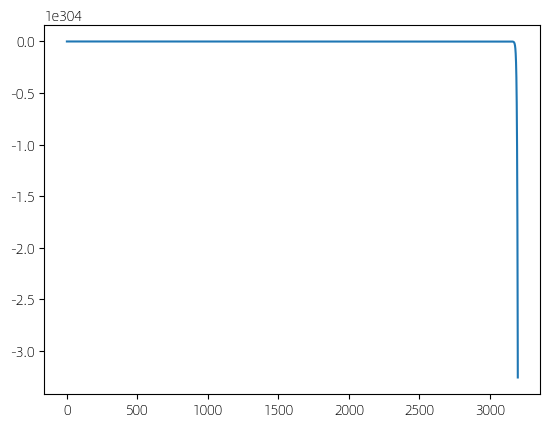

In [117]:
voltage = np.arange(0,1.2*xdata.max(),0.01)
current = popt[1]*(1 - popt[2]*(np.exp(voltage/(popt[3]*popt[0]))-1))
# print(len(current),len(voltage))
plt.plot(voltage,current)

In [158]:
actions=[-10, -5, -3, -2, -1, -0.1, 0, 0.1, 1, 2, 3, 5, 10]

In [160]:
actions[9]

2

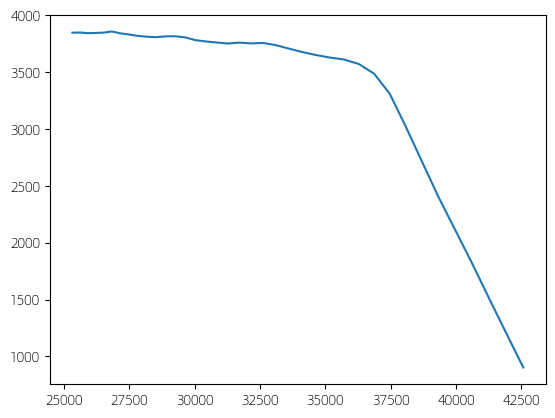

In [120]:
plt.plot(xdata,ydata)

In [119]:
for ll in df.final_label.unique():
    df_ll = df[df.final_label==ll]
    if df_ll.shape[0]<30:
        continue

    res[ll] = pv.generate_pv_curve(df_ll.voltage,df_ll.current,ll)
    lenth = {'lenth':df_lla.shape[0]}
    res[ll].update(lenth)
                                                       


AttributeError: 'DataFrame' object has no attribute 'final_label'

In [26]:
alpha = -0.0358
beta = 0.35
gamma = 0.00288
S,T = 169,15.8
print('辐照',S,'气温',T)
dT = T - T_std
dS = S/S_std -1
u_oc_new = pv.Voc*(1-gamma*dT)*(1+beta*dS)
u_mmp_new = pv.Vmmp*(1+gamma*dT)*(1+beta*dS)
# print(dS,dT)
i_sc_new = pv.Isc*(1+alpha*dT)*S/S_std
i_mmp_new = pv.Immp*(1+alpha*dT)*S/S_std
# print(u_oc_new,u_mmp_new,i_sc_new,i_mmp_new)
c2 = (u_mmp_new/u_oc_new-1)/np.log(1-(i_mmp_new/i_sc_new))
c1 = (1-(i_mmp_new/i_sc_new))*np.exp(-u_mmp_new/(c2*u_oc_new))
print('组件参数',u_oc_new,u_mmp_new,i_sc_new,i_mmp_new)
voltage = np.arange(0,u_oc_new,0.01)
current = i_sc_new*(1 - c1*(np.exp(voltage/(c2*u_oc_new))))
# print(len(current),len(voltage))

plot_curve(voltage,current,df_lla.voltage,df_lla.current,'label',S,T)


辐照 169 气温 15.8
组件参数 42.220499027200006 31.542564921504002 3.3407215607999996 3.0239483664


NameError: name 'df_lla' is not defined

SyntaxError: invalid syntax (3393039278.py, line 1)

In [27]:
fit_df = pd.DataFrame(res).T

In [28]:
fit_df.sort_values('lenth')

KeyError: 'lenth'

In [29]:
df = df[df['label_2'] in fit_df.index]

KeyError: 'label_2'

In [30]:
df[df['label_2'] == '1882-b']

KeyError: 'label_2'

In [31]:
fit_df.reset_index(inplace=True)

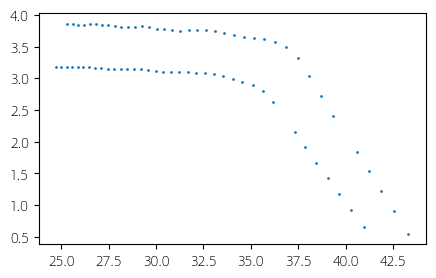

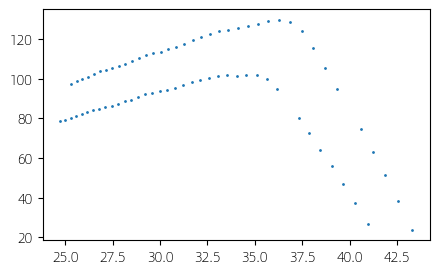

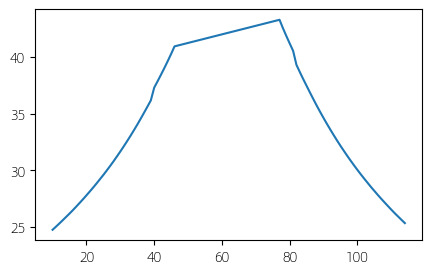

<Figure size 500x300 with 0 Axes>

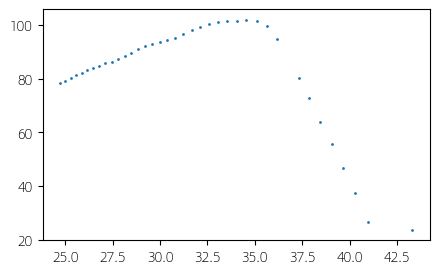

In [33]:
tt= df[df.label==11]
fig = plt.figure(figsize=[5,3])
plt.plot(tt.voltage,tt.current,'o',markersize='1')
fig = plt.figure(figsize=[5,3])
plt.plot(tt.voltage,tt.power,'o',markersize='1')
fig = plt.figure(figsize=[5,3])
tt['voltage'].plot()
fig = plt.figure(figsize=[5,3])
ss = tt[tt.index<=tt.voltage.idxmax()]
fig = plt.figure(figsize=[5,3])
plt.plot(ss.voltage,ss.power,'o',markersize='1')

In [34]:
import numpy as np
from sklearn.svm import OneClassSVM
model = OneClassSVM(kernel='rbf',gamma= 0.1,nu=0.3)
model.fit(ss[['voltage','current']].values)
model.predict(ss[['voltage','current']].values)

array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1,
        1,  1, -1, -1])

In [35]:
from sklearn.cluster import KMeans
n_clusters = 2
model = KMeans(n_clusters = n_clusters, random_state = 0).fit(ss[['voltage','current']].values)
# ss['class'] = list(model.predict(ss[['voltage','current']].values))

In [36]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=2, min_samples=2,algorithm='auto',metric='minkowski',p=2).fit(ss[['voltage','current']].values) 

In [37]:
ss['class'] = db.labels_


/var/folders/s5/xbvm2xtj3wq717lj2kf2s1j80000gn/T/ipykernel_29343/1399941873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss['class'] = db.labels_


In [38]:
# model.predict(ss[['voltage','current']].values)

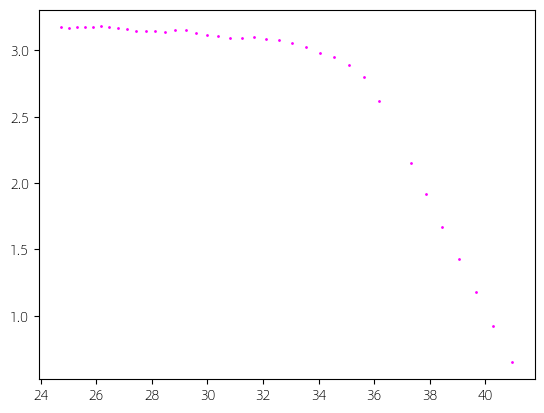

In [39]:
plt.plot(ss[ss['class']==1].voltage,ss[ss['class']==1].current,'o',markersize=1,color='#00ff00')
plt.plot(ss[ss['class']==0].voltage,ss[ss['class']==0].current,'o',markersize=1,color='#ff00ff')

In [39]:
ss['class'].unique()

array([ 0, -1])

In [40]:
popt, pcov = curve_fit(func_pv, u_pv[0:3], i_pv[0:3],p0=[20,500])


NameError: name 'func_pv' is not defined

In [41]:
y_pred = [func_pv(i, popt[0],popt[1]) for i in u_pv]
plt.plot(u_pv,y_pred,'r--')
plt.plot(u_pv,i_pv,'g--')
from sklearn.metrics import r2_score
r2 = r2_score(i_pv , y_pred )
print('指数函数拟合R方为:',r2)
print(popt)
print(pcov)

NameError: name 'func_pv' is not defined

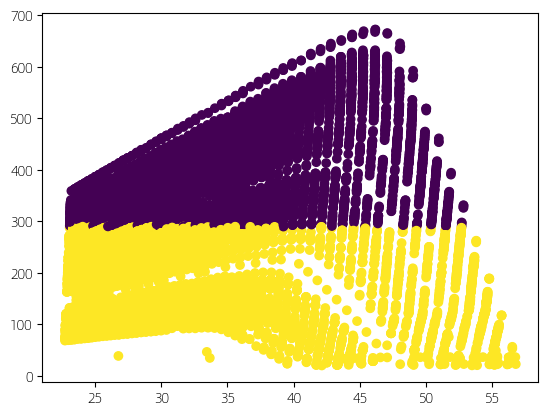

In [42]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[['voltage','power']].values)
plt.scatter(df['voltage'],df['power'], c = kmeans.labels_)

In [170]:
from urllib import parse, request
import json
import requests
import base64
import cv2

# parameter=dict()
# parameter['text'] = 'test'
# with open('../QR-Code-Extractor/input/测试2.jpg', 'rb') as f:
#     image_bytes = base64.b64encode(f.read())
#     # print(f.read().shape)
#     image_bytes = image_bytes.decode()
# img = image_bytes
# img = cv2.imdecode(img, cv2.COLOR_RGB2GRAY)
img=cv2.imread('../QR-Code-Extractor/input/测试2.jpg')

In [171]:
img.shape

(3240, 5760, 3)

In [371]:
env = pd.read_csv('data/训练用辐照.csv',index_col=0)

In [391]:
env.Temp.min()

15.88888931

In [36]:
a =random.randint(0,10)

In [37]:
a

4